<a href="https://colab.research.google.com/github/baba410/1082python/blob/master/VAE%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [0]:
##資料整理


In [0]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
x = Input(shape=(784,))

In [0]:
##建立VAE模型

In [0]:
enc_1 = Dense(100, activation='sigmoid') 
enc_2 = Dense(235, activation='relu') 
enc_3 = Dense(235, activation='sigmoid') 

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(150, activation='sigmoid') 
dec_2 = Dense(350, activation='sigmoid') 
dec_1 = Dense(784, activation='sigmoid') 

In [0]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon 

In [0]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [0]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)

In [0]:
##summary

In [41]:
VAE.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 100)          78500       input_7[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 235)          23735       dense_16[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 2)            472         dense_17[0][0]                   
____________________________________________________________________________________________

In [0]:
##建立Loss Function

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.7 ##-0.7
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

In [0]:
##fit

In [59]:
VAE.fit(X_train, 
        batch_size=256,
        epochs=15)

Epoch 1/15
235/235 [==============================] - 5s 20ms/step - loss: 498.7376
Epoch 2/15
235/235 [==============================] - 5s 20ms/step - loss: 498.7235
Epoch 3/15
235/235 [==============================] - 5s 20ms/step - loss: 498.7140
Epoch 4/15
235/235 [==============================] - 5s 20ms/step - loss: 498.7068
Epoch 5/15
235/235 [==============================] - 5s 20ms/step - loss: 498.7049
Epoch 6/15
235/235 [==============================] - 5s 21ms/step - loss: 498.7025
Epoch 7/15
235/235 [==============================] - 5s 20ms/step - loss: 498.6982
Epoch 8/15
235/235 [==============================] - 5s 20ms/step - loss: 498.6956
Epoch 9/15
235/235 [==============================] - 5s 20ms/step - loss: 498.6913
Epoch 10/15
235/235 [==============================] - 5s 20ms/step - loss: 498.6548
Epoch 11/15
235/235 [==============================] - 5s 20ms/step - loss: 498.5919
Epoch 12/15
235/235 [==============================] - 5s 20ms/step - loss

In [0]:
##VAE視覺化

In [61]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_17 (Dense)             (None, 235)               23735     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 472       
Total params: 102,707
Trainable params: 102,707
Non-trainable params: 0
_________________________________________________________________


In [62]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_22 (Dense)             (None, 350)               52850     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               275184    
Total params: 328,484
Trainable params: 328,484
Non-trainable params: 0
_________________________________________________________________


In [63]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 54703 圖的 latent 表示為 [0.8813397  0.00131794]


In [0]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

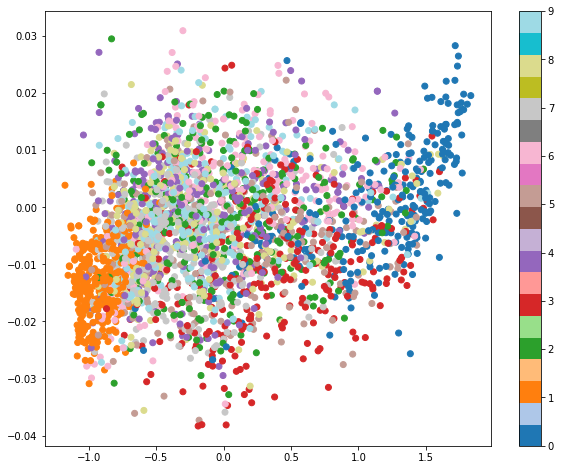

In [65]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [0]:
#Decoder 的視覺化呈現

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 26
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

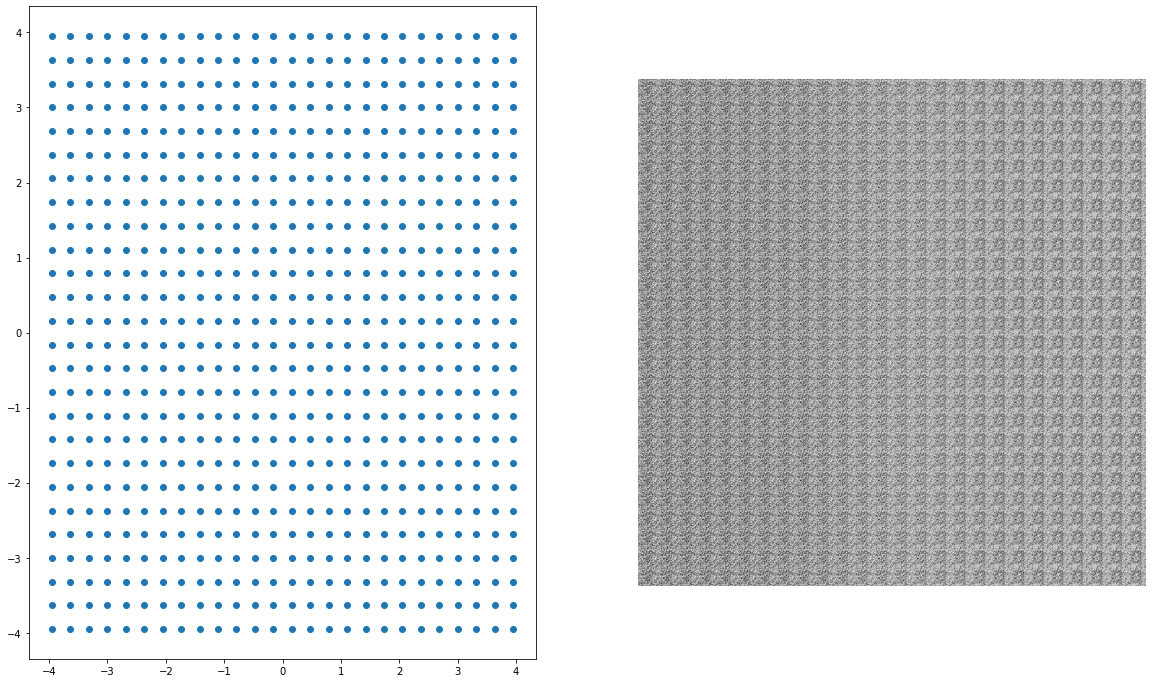

In [71]:
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()